In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
airData = pd.read_csv(r"C:\Users\hp\Downloads\air_quality_data.csv", index_col = "No")

## Replacing missing values

In [23]:
# Check missing values
missing_values = airData.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check skewness for numerical columns
numerical_cols = airData.select_dtypes(include=[np.number]).columns
skewness = airData[numerical_cols].skew()

# Define threshold for skewness
skew_threshold = 0.5
imputation_suggestions = {}

for col in numerical_cols:
    if missing_values[col] > 0:  # Only check for columns with missing values
        if abs(skewness[col]) < skew_threshold:
            imputation_suggestions[col] = 'Mean'
        else:
            imputation_suggestions[col] = 'Median'

print("\nImputation Suggestions:")
for col, method in imputation_suggestions.items():
    print(f"{col}: {method}")

Missing Values:
 PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64

Imputation Suggestions:
PM2.5: Median
PM10: Median
SO2: Median
NO2: Median
CO: Median
O3: Median
TEMP: Mean
PRES: Mean
DEWP: Mean
RAIN: Median
WSPM: Median


In [24]:
airData['PM2.5']=airData['PM2.5'].fillna(airData['PM2.5'].median())
airData['PM10']=airData['PM10'].fillna(airData['PM10'].median())
airData['SO2']=airData['SO2'].fillna(airData['SO2'].median())
airData['NO2']=airData['NO2'].fillna(airData['NO2'].median())
airData['CO']=airData['CO'].fillna(airData['CO'].median())
airData['O3']=airData['O3'].fillna(airData['O3'].median())
airData['TEMP']=airData['TEMP'].fillna(airData['TEMP'].mean())
airData['PRES']=airData['PRES'].fillna(airData['PRES'].mean())
airData['DEWP']=airData['DEWP'].fillna(airData['DEWP'].mean())
airData['RAIN']=airData['RAIN'].fillna(airData['RAIN'].median())
airData['WSPM']=airData['WSPM'].fillna(airData['WSPM'].median())
airData['wd']=airData['wd'].fillna(airData['wd'].mode()[0])

In [25]:
airData.isnull().sum()

year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

## Checking distribution of columns

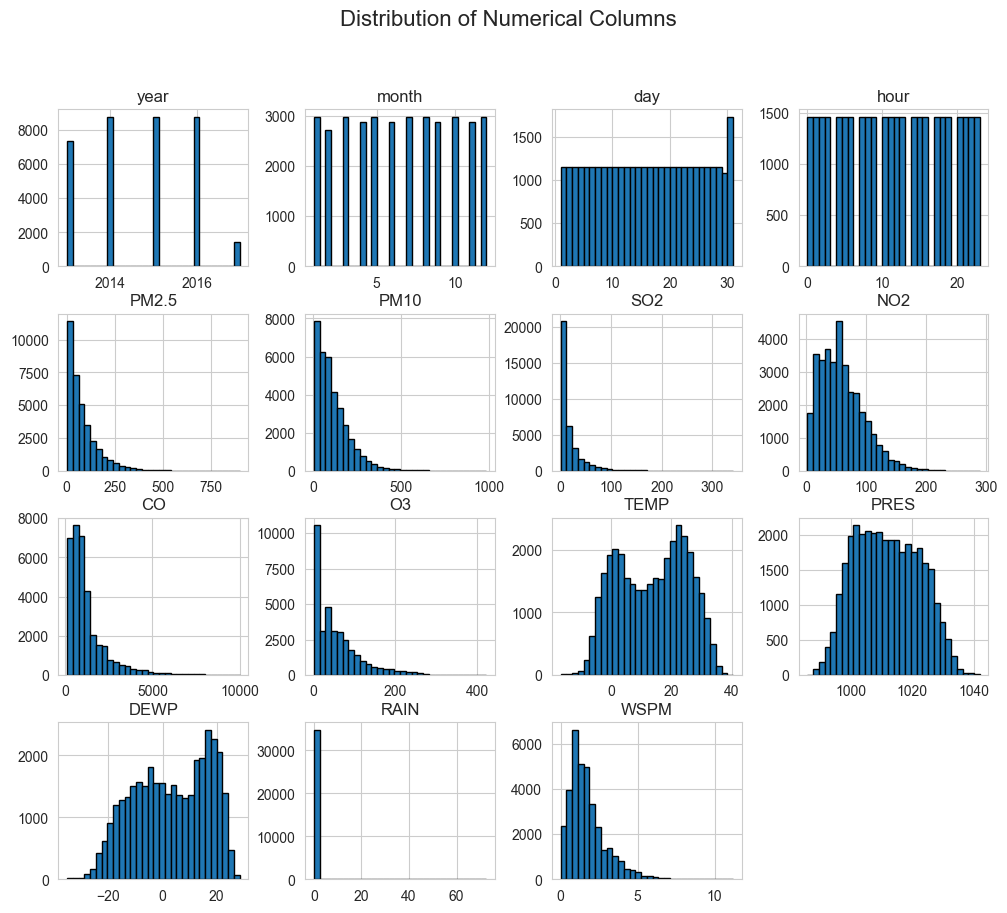

In [27]:
sns.set_style("whitegrid")

# Select only numerical columns
numerical_cols = airData.select_dtypes(include=['number']).columns

# Plot histograms for each numerical column
airData[numerical_cols].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numerical Columns", fontsize=16)
plt.show()

## Checking Outliers using Box-Plots

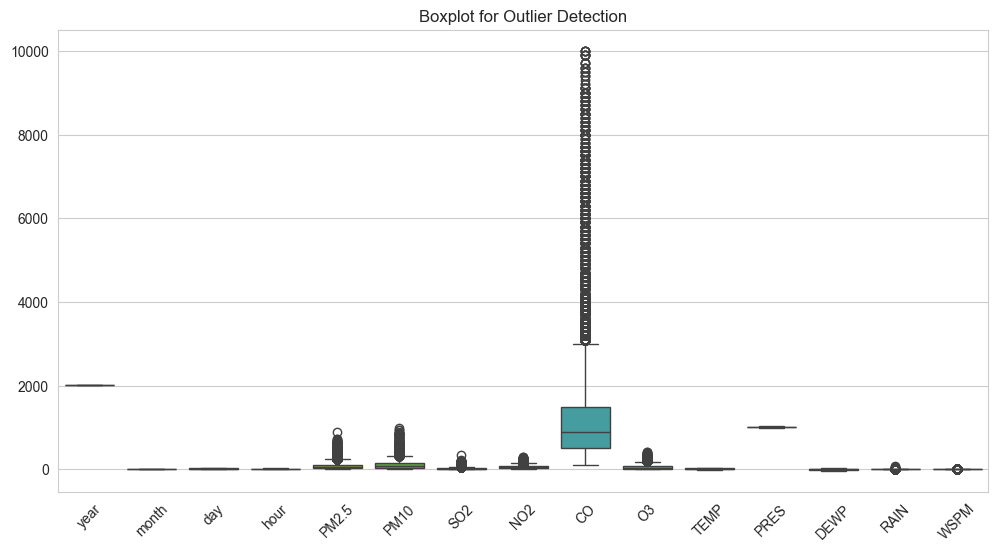

year: 0 outliers detected
month: 0 outliers detected
day: 0 outliers detected
hour: 0 outliers detected
PM2.5: 1768 outliers detected
PM10: 1151 outliers detected
SO2: 3054 outliers detected
NO2: 566 outliers detected
CO: 2607 outliers detected
O3: 1491 outliers detected
TEMP: 0 outliers detected
PRES: 0 outliers detected
DEWP: 0 outliers detected
RAIN: 1380 outliers detected
WSPM: 1742 outliers detected


In [29]:
# Boxplot for visualizing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=airData.select_dtypes(include=[np.number]))
plt.xticks(rotation=45)
plt.title("Boxplot for Outlier Detection")
plt.show()

# IQR method to detect outliers
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    return outliers

# Detect outliers
outlier_dict = detect_outliers_iqr(airData, airData.select_dtypes(include=[np.number]).columns)

# Print the number of outliers per column
for col, outliers in outlier_dict.items():
    print(f"{col}: {len(outliers)} outliers detected")

## Adjusting Outliers

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Normalize pollutant levels using Min-Max Scaling
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
scaler = MinMaxScaler()
airData[pollutants] = scaler.fit_transform(airData[pollutants])

# Convert RAIN into a binary feature
airData['RAIN'] = (airData['RAIN'] > 0).astype(int)

# Keep WSPM log-transformed
airData['WSPM'] = np.log1p(airData['WSPM'])  # log(1+x) to handle zeros safely

## Checking for inconsistent data values

In [34]:
# Check for negative values in pollutant columns
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
negative_pollutants = airData[pollutants][airData[pollutants] < 0].dropna(how='all')

# Check for unrealistic weather data
invalid_weather = airData[(airData['TEMP'] < -50) | (airData['TEMP'] > 60) |  # Extreme unrealistic temperatures
                     (airData['PRES'] < 850) | (airData['PRES'] > 1100) |  # Pressure outside normal range
                     (airData['WSPM'] < 0)]  # Wind speed should never be negative

# Check for date inconsistencies
invalid_dates = airData[(airData['month'] > 12) | (airData['month'] < 1) |  # Valid months: 1-12
                   (airData['day'] > 31) | (airData['day'] < 1)]  # Valid days: 1-31

# Check for inconsistent hours
invalid_hours = airData[(airData['hour'] > 23) | (airData['hour'] < 0)]  # Valid hours: 0-23

# Print findings
print(f"Negative pollutant values found:\n{negative_pollutants}")
print(f"Unrealistic weather data found:\n{invalid_weather}")
print(f"Invalid dates found:\n{invalid_dates}")
print(f"Inconsistent hours found:\n{invalid_hours}")

# Optionally remove/adjust invalid data
airData[pollutants] = airData[pollutants].clip(lower=0)  # Set negative values to 0
airData['WSPM'] = airData['WSPM'].clip(lower=0)  # Ensure wind speed is non-negative
airData = airData[(airData['hour'] >= 0) & (airData['hour'] <= 23)]  # Keep only valid hours
airData = airData[(airData['month'] >= 1) & (airData['month'] <= 12)]  # Keep only valid months
airData = airData[(airData['day'] >= 1) & (airData['day'] <= 31)]  # Keep only valid days

Negative pollutant values found:
Empty DataFrame
Columns: [PM2.5, PM10, SO2, NO2, CO, O3]
Index: []
Unrealistic weather data found:
Empty DataFrame
Columns: [year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []
Invalid dates found:
Empty DataFrame
Columns: [year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []
Inconsistent hours found:
Empty DataFrame
Columns: [year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, station]
Index: []


## Feature Engineering

In [38]:
# Add Air Quality Index (AQI) column
airData['air_quality_index'] = (airData['PM2.5'] + airData['PM10'] + airData['NO2'] + airData['O3']) / 4

# Categorize air quality levels
def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    else:
        return "Unhealthy"

airData['pollution_level'] = airData['air_quality_index'].apply(categorize_aqi)

# Categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

airData['season'] = airData['month'].apply(get_season)

# Categorize as weekday or weekend
airData['weekday'] = airData['day'].apply(lambda x: "Weekend" if x in [6, 7] else "Weekday")

In [40]:
airData.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,PRES,DEWP,RAIN,wd,WSPM,station,air_quality_index,pollution_level,season,weekday
No,,,,,,,,,,,,,,,,,,,,,
1,2013,3,1,0,0.001117,0.002037,0.010902,0.017361,0.020202,0.181619,...,1023.0,-18.8,0,NNW,1.686399,Aotizhongxin,0.050533,Good,Spring,Weekday
2,2013,3,1,1,0.005587,0.006110,0.010902,0.017361,0.020202,0.181619,...,1023.2,-18.2,0,N,1.740466,Aotizhongxin,0.052669,Good,Spring,Weekday
3,2013,3,1,2,0.004469,0.005092,0.013837,0.027778,0.020202,0.172158,...,1023.5,-18.2,0,NNW,1.887070,Aotizhongxin,0.052374,Good,Spring,Weekday
4,2013,3,1,3,0.003352,0.004073,0.031447,0.031250,0.020202,0.169792,...,1024.5,-19.4,0,NW,1.410987,Aotizhongxin,0.052117,Good,Spring,Weekday
5,2013,3,1,4,0.000000,0.001018,0.034382,0.034722,0.020202,0.169792,...,1025.2,-19.5,0,N,1.098612,Aotizhongxin,0.051383,Good,Spring,Weekday


## Visualizations

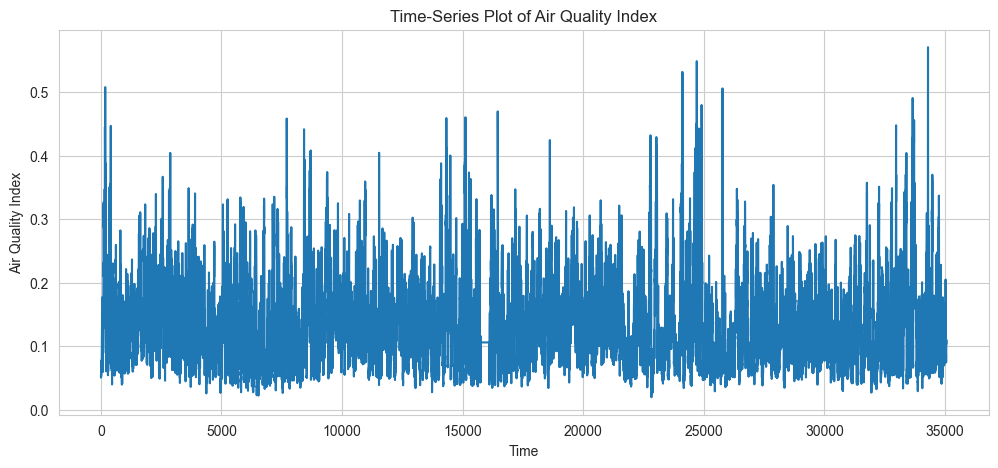

In [43]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=airData.index, y=airData['air_quality_index'])
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.title('Time-Series Plot of Air Quality Index')
plt.show()

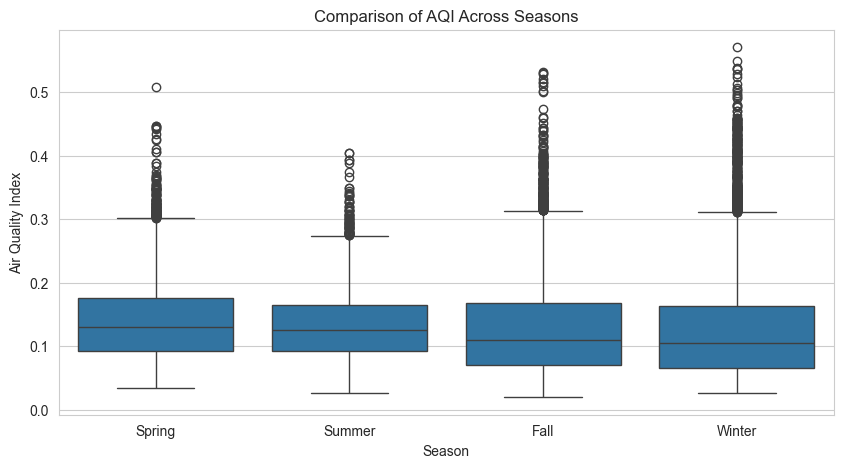

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='season', y='air_quality_index', data=airData)
plt.xlabel('Season')
plt.ylabel('Air Quality Index')
plt.title('Comparison of AQI Across Seasons')
plt.show()

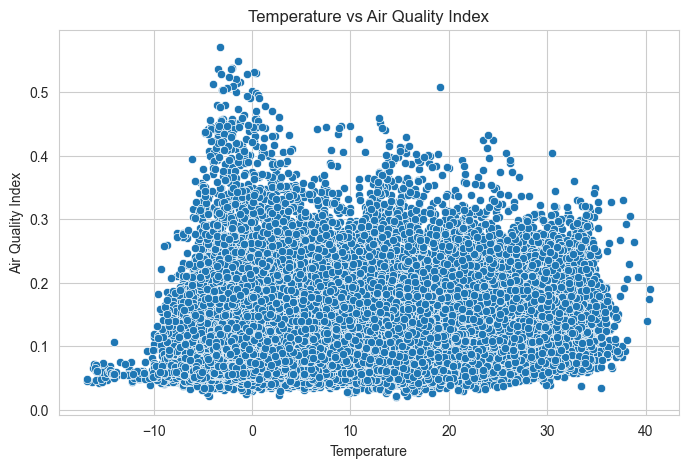

In [45]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=airData['TEMP'], y=airData['air_quality_index'])
plt.xlabel('Temperature')
plt.ylabel('Air Quality Index')
plt.title('Temperature vs Air Quality Index')
plt.show()

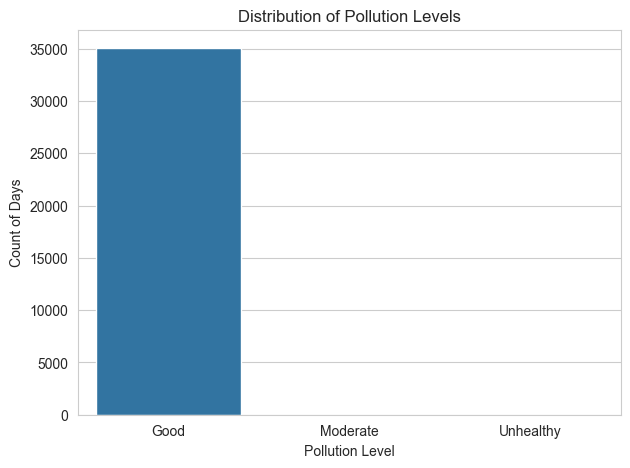

In [46]:
plt.figure(figsize=(7, 5))
sns.countplot(x='pollution_level', data=airData, order=["Good", "Moderate", "Unhealthy"])
plt.xlabel('Pollution Level')
plt.ylabel('Count of Days')
plt.title('Distribution of Pollution Levels')
plt.show()

#### There are only good pollution levels suggesting that the formula used is incorrect in terms of scale. Real-world AQI calculations involve more complex weightings and breakpoints.

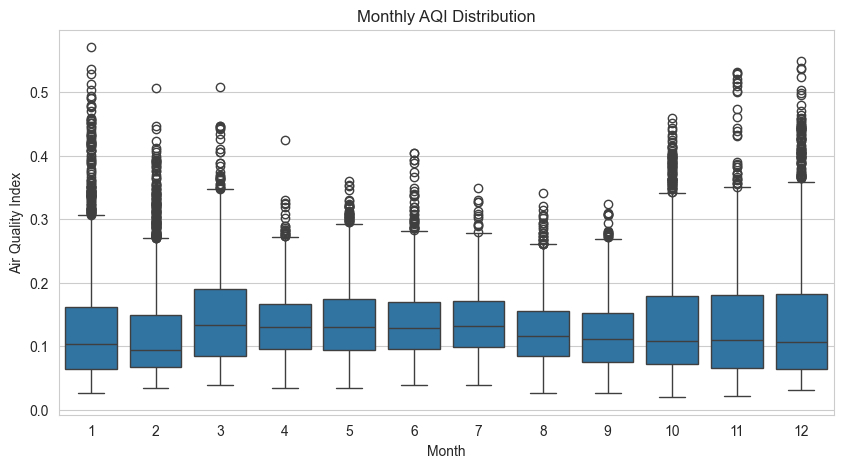

In [47]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='air_quality_index', data=airData)
plt.xlabel('Month')
plt.ylabel('Air Quality Index')
plt.title('Monthly AQI Distribution')
plt.show()

## Insights from the Visualizations:

### Time-Series Plot of Air Quality Index:

####         The AQI fluctuates significantly over time, with noticeable peaks.

####        There are no extreme values indicating highly polluted periods, which aligns with the dataset showing only "Good" pollution levels.

####        Some seasonal variations might be present, but more analysis is needed.

### Comparison of AQI Across Seasons (Box Plot):

####       The AQI distributions are similar across all seasons.

####         There are many outliers in each season, but the median values remain relatively consistent.

####         No significant seasonal trend is visible, meaning pollution levels do not change drastically between seasons.

### Temperature vs. AQI (Scatter Plot):

####         There is a weak but visible trend where AQI increases at lower temperatures.

####         The highest AQI values are observed when temperatures are near or below 0°C.

####         This suggests that colder months might have slightly higher air pollution levels.

### Monthly AQI Distribution (Box Plot):

####         A similar pattern to the seasonal box plot, showing no extreme month-to-month variation.

####         Outliers are more frequent in colder months (January, February, and December).

####         The median AQI levels remain stable across months.

### Key Takeaways:

####     The dataset categorizes all AQI values as "Good," which might indicate an issue with AQI threshold settings or data scaling.

####     There are no major seasonal or monthly fluctuations in air quality.

####     Temperature might have a slight effect on air pollution, but it's not very strong.

####     The AQI formula needs refinement, consider different weightings for pollutants or using official AQI standards.